In [2]:
import pandas as pd
import numpy as np

In [3]:
fifa = pd.read_csv('results.csv')

In [4]:
fifa.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


### 1- What's the country with the biggest number of wins

In [6]:
def get_winner(row):
    winner = ""
    if row['home_score'] > row['away_score']:
        winner = row['home_team']
    elif row['home_score'] < row['away_score']:
        winner = row['away_team']
    else:
        winner = np.nan
    return winner

fifa['winner_of_match'] = fifa.apply(lambda x : get_winner(x), axis=1)

In [7]:
winner_df = fifa.groupby('winner_of_match').count()[['neutral']]

#We chose the neutral because it doesn't matter (all of the columns contained the same value)
winner_df.rename(columns={'neutral':'won_games'}, inplace = True)

winner_df.sort_values(ascending=False,by = ['won_games'], inplace = True) 

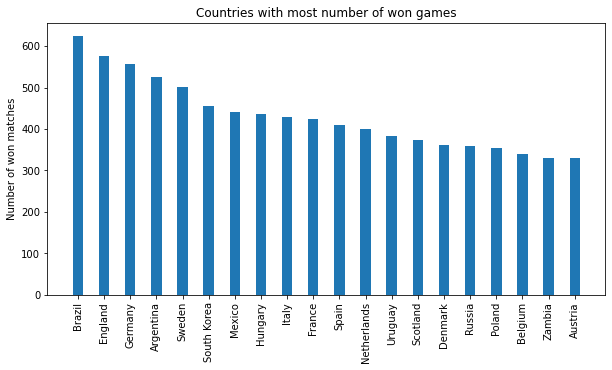

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5)) 

plt.bar(winner_df.index[:20], winner_df['won_games'][:20],width = 0.4)

plt.xticks(rotation = 90)

plt.ylabel('Number of won matches')

plt.title('Countries with most number of won games')

plt.show()

### 2- Is there a correlation between number of won games and being the host of the match?


In [9]:
#We group by country because sometimes the match can be neutral
#Again, all the columns have the same value so it doesn't matter what we choose.
win_host = fifa.groupby('country').count()[['neutral']]

win_host.rename(columns={'neutral':'hosted_matches'},inplace=True)

win_host['won_games'] = winner_df['won_games']


In [10]:
win_host.head()

,hosted_matches,won_games
country,,
Afghanistan,8,30.0
Albania,167,88.0
Algeria,203,215.0
Andorra,68,6.0
Angola,156,122.0


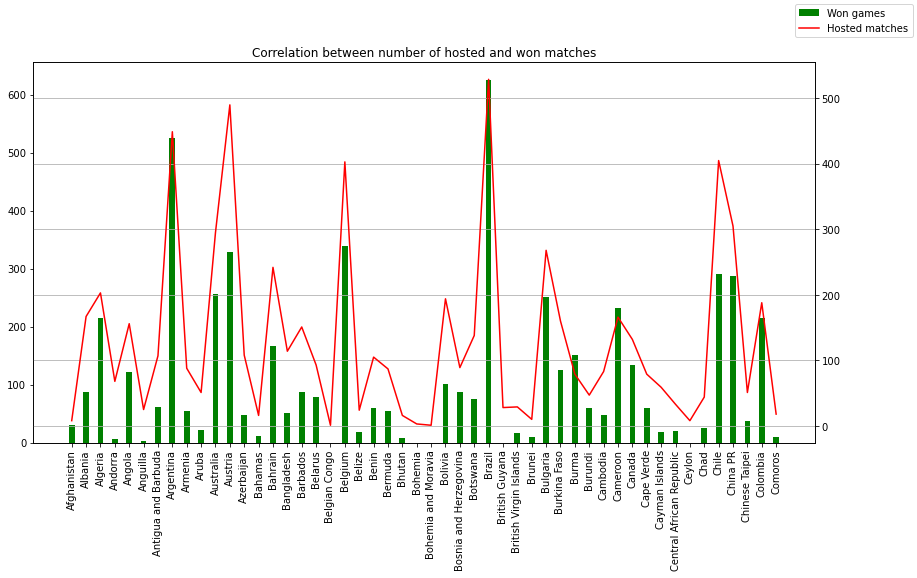

In [11]:
#We plot only the first 50 registers because of space.

fig = plt.figure(figsize = (14,7)) 
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()

ax1.bar(win_host.index[:50], win_host['won_games'][:50],color='green',width=0.4, label='Won games')
ax2.plot(win_host.index[:50], win_host['hosted_matches'][:50], '-r', label = 'Hosted matches')

ax1.set_xticklabels(win_host.index[:50], rotation=90)

plt.grid()

plt.title('Correlation between number of hosted and won matches')

fig.legend(labels=['Won games','Hosted matches'])

plt.show()

### 3- Normal distribution of average goals

In [12]:
avg_home_goals_per_country = fifa.groupby('home_team').mean()['home_score']
avg_home_goals_per_country.head()

home_team
Abkhazia       2.000000
Afghanistan    1.275000
Albania        1.134078
Alderney       0.714286
Algeria        1.784247
Name: home_score, dtype: float64

In [13]:
avg_away_goals_per_country = fifa.groupby('away_team').mean()['away_score']
avg_away_goals_per_country.head()

away_team
Abkhazia       1.200000
Afghanistan    0.887324
Albania        0.700000
Alderney       0.833333
Algeria        0.879070
Name: away_score, dtype: float64

In [14]:
avg_goals = (avg_home_goals_per_country+avg_away_goals_per_country)/2

avg_goals.head()

Abkhazia       1.600000
Afghanistan    1.081162
Albania        0.917039
Alderney       0.773810
Algeria        1.331658
dtype: float64

C:\Users\Diego\anaconda3\envs\machine\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Diego\anaconda3\envs\machine\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


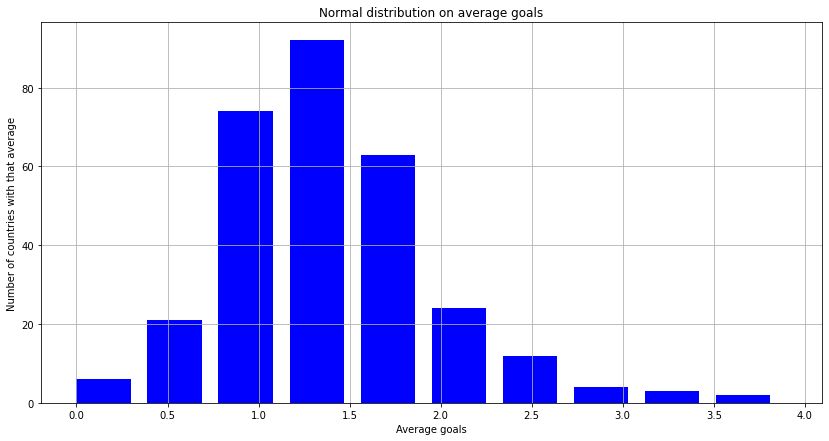

In [15]:
fig = plt.figure(figsize = (14,7)) 

plt.hist(avg_goals,width=0.3,color='blue')


plt.ylabel('Number of countries with that average')
plt.xlabel('Average goals')
plt.title('Normal distribution on average goals')


plt.grid()
plt.show()

### Top 10 rivalries 

In [16]:
copy_df = fifa.copy()

copy_df['matches_played'] = 1

In [17]:
def sum_home_team_matches(row):
    winner = get_winner(row)
    if winner == row['home_team']:
        return 1
    elif winner == row['away_team']:
        return 0
    else: 
        return np.nan

def sum_away_team_matches(row):
    winner = get_winner(row)
    if winner == row['away_team']:
        return 1
    elif winner == row['home_team']:
        return 0
    else: 
        return np.nan


copy_df['home_winning'] = copy_df.apply(lambda x : sum_home_team_matches(x), axis=1)

copy_df['away_winning'] = copy_df.apply(lambda x : sum_away_team_matches(x), axis=1)

In [18]:
results = copy_df.groupby(by=['home_team','away_team']).sum()[['matches_played','home_winning','away_winning']].reset_index()

shifted_results = results.copy()

In [19]:
#The output shows that Argentina won 81 matches. This can be used later to confirm we did no mistakes
a = results[results['home_team']=='Argentina']
print(a[a['away_team']=='Uruguay'])
u = results[results['home_team']=='Uruguay']
print(u[u['away_team']=='Argentina'])


     home_team away_team  matches_played  home_winning  away_winning
421  Argentina   Uruguay              96          60.0          16.0
      home_team  away_team  matches_played  home_winning  away_winning
10493   Uruguay  Argentina              80          36.0          21.0


In [20]:
#We shift the results
shifted_results.loc[shifted_results['home_team']>shifted_results['away_team'],
                    ['home_team','away_team','home_winning','away_winning'] ] = (
                        shifted_results.loc[shifted_results['home_team']>shifted_results['away_team'], 
                                            ['away_team','home_team','away_winning','home_winning'] ].values)

In [21]:
results = shifted_results.groupby(by=['home_team','away_team']).sum().reset_index()

In [22]:
results.head()

,home_team,away_team,matches_played,home_winning,away_winning
0,Abkhazia,Artsakh,3,0.0,1.0
1,Abkhazia,Chagos Islands,1,1.0,0.0
2,Abkhazia,Chameria,2,1.0,0.0
3,Abkhazia,Kabylia,1,1.0,0.0
4,Abkhazia,Kárpátalja,2,0.0,1.0


In [23]:
#We can see that the data shows exactly the same values as the example above (Argentina has 81 winning vs Uruguay)
results[results['home_team']=='Argentina']

,home_team,away_team,matches_played,home_winning,away_winning
430,Argentina,Australia,7,5.0,1.0
431,Argentina,Austria,2,1.0,0.0
432,Argentina,Belarus,1,0.0,0.0
433,Argentina,Belgium,4,3.0,1.0
434,Argentina,Bolivia,35,24.0,6.0
...,...,...,...,...,...
501,Argentina,United States,10,6.0,2.0
502,Argentina,Uruguay,176,81.0,52.0
503,Argentina,Venezuela,25,21.0,2.0
504,Argentina,Wales,2,1.0,0.0


In [24]:
#Rename columns for a better understanding
results.rename(columns={'home_team':'Team_1','away_team':'Team_2',
                        'home_winning':'Team_1_winnings','away_winning':'Team_2_winnings',
                       'matches_played':'Total_matches'},inplace=True)

In [25]:
sorted_results = results.sort_values(by=['Total_matches'],ascending=False)

sorted_results.reset_index(inplace=True)
sorted_results.head(10)

,index,Team_1,Team_2,Total_matches,Team_1_winnings,Team_2_winnings
0,502,Argentina,Uruguay,176,81.0,52.0
1,724,Austria,Hungary,133,39.0,65.0
2,1126,Belgium,Netherlands,125,40.0,54.0
3,3239,England,Scotland,116,48.0,42.0
4,6052,Norway,Sweden,107,24.0,58.0
5,2946,Denmark,Sweden,107,41.0,46.0
6,5016,Kenya,Uganda,107,32.0,41.0
7,6490,Scotland,Wales,106,61.0,23.0
8,3254,England,Wales,104,68.0,15.0
9,436,Argentina,Brazil,104,37.0,43.0


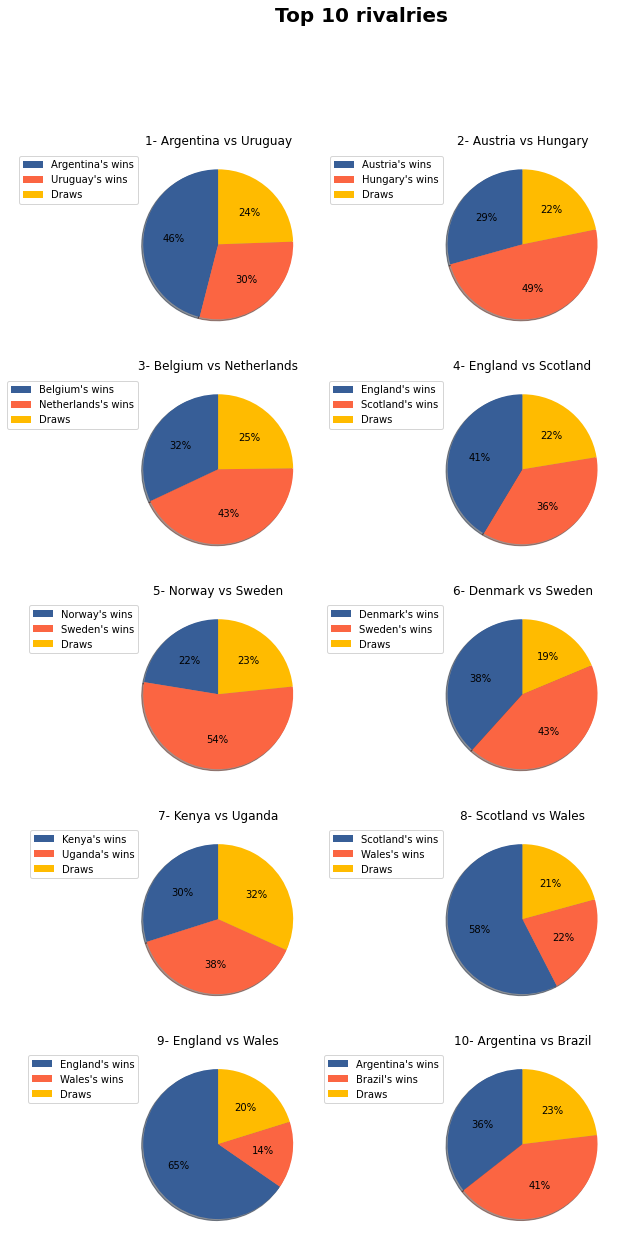

In [41]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

colors = ['#375E97','#FB6542','#FFBB00']

number_of_chart = 0

for i in range(5):
    for j in range(2):
        
        t1 = sorted_results['Team_1_winnings'][number_of_chart]*100/sorted_results['Total_matches'][number_of_chart]
        
        t2 = sorted_results['Team_2_winnings'][number_of_chart]*100/sorted_results['Total_matches'][number_of_chart]
        
        draw = 100-t1-t2
        
        sizes = [t1,t2,draw]
        
        t1name = sorted_results['Team_1'][number_of_chart]
        t2name = sorted_results['Team_2'][number_of_chart]
        
        labels = [t1name+"'s wins",t2name+"'s wins",'Draws']
        
        ax[i,j].pie(sizes, startangle=90, colors=colors, autopct='%1.f%%', shadow=True)
        ax[i,j].set_title(str(number_of_chart+1)+"- "+t1name+" vs "+t2name)

        ax[i,j].legend(labels = labels, loc='best', bbox_to_anchor=(0, 0, 0.1, 1))
        
        
        number_of_chart+=1
        
plt.suptitle('Top 10 rivalries', fontsize=20, fontweight='bold')

plt.show()